# Machine Learning and HR

![/images/employee_attrition.jpg](images/employee_attrition.jpg)

## Predicting Employee Attrition

## Overview and Business Problem

Employee attrition is one of the more costly recurring expenses at any company. Not only are you losing the institutional knowledge that person has learned on the job which makes them very effective (especially if they've been on the job for a number of years), but you are also paying for lost productivity, and the time it takes to hire someone new, as it prevents current employees from fully doing their own jobs. According to [IBM](https://toggl.com/blog/employee-attrition), the cost of attrition can be 1.5x the salary of the employee who left, and for a mid-size company, up to $6.75 million a year.

Any profit-maximizing firm would want to reduce attrition. Lower attrition is less costly, and generally means that your employees are happy, and in turn, productive. HR data is an extremely valuable resource and can be highly advantageous to companies who take time to learn it. Employees tend to be a company's most important assets, and understanding the factors causing them to leave is invaluable.

This project will go into what factors lead to employee attrition, using an employee dataset from IBM. We are hoping to develop a model that results in a very low **false negative rate**. This would mean our model rarely misses employees who decide to leave. In practice, this model could be used to help employers address areas making employees unhappy and unproductive, and which ones are most likely to leave. This will provide them with the data to step in and support employees before the leave and develop better HR policies that make employees feel welcome.

## Data Understanding

The data, created by IBM data scientists, comes from [Kaggle](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset). There are 1470 rows, each representing one employee. There 30 attributes for each employee, and whether they left the company or not. Some of these attributes are:

- Age
- Job satisfaction
- Education
- Total working years
- Job role
- Distance from home
- and monthly income

Using these features, I will test out different classification models and fine-tune the model that best reduces the false negative rate (best recall score).

In [1]:
#Library imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
#evaluate function

def evaluate(estimator, X_train, X_test, y_train, y_test, use_decision_function='yes'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    use_decision_function allows you to toggle whether you use decision_function or
    predict_proba in order to get the output needed for roc_auc_score
    If use_decision_function == 'skip', then it ignores calculating the roc_auc_score
    
    courtesy of Lindsey Berlin
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # output needed for roc_auc_score
    if use_decision_function == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif use_decision_function == 'yes': # not all classifiers have decision_function
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif use_decision_function == 'no':
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception ("The value for use_decision_function should be 'skip', 'yes' or 'no'.")

    print(type(test_out))
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"Recall: {recall_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    if type(train_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"Recall: {recall_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")
    if type(test_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test)
    plt.show()

In [3]:
#load data

df = pd.read_csv('HR_Employee_Attrition.csv')

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


This dataset has 1470 rows and 35 columns. Let's show the categorical and numeric column breakdown

In [4]:
cat_cols = []
num_cols = []

for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        num_cols.append(col)
    else:
        cat_cols.append(col)

df[cat_cols].describe()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1470,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,6,2,9,3,1,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,1233,1043,961,606,882,326,673,1470,1054


In [5]:
df[num_cols].describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [6]:
#removing meaningless columns and converting Attrition to 1/0 fomr yes/no

df.drop(columns = ['Over18', 'EmployeeNumber', 'EmployeeCount', 'StandardHours'], axis=1, inplace = True)
df['Attrition'] = df['Attrition'].map({'Yes':1, 'No':0})

0    0.838776
1    0.161224
Name: Attrition, dtype: float64


Text(0.5, 1.0, 'Attrition')

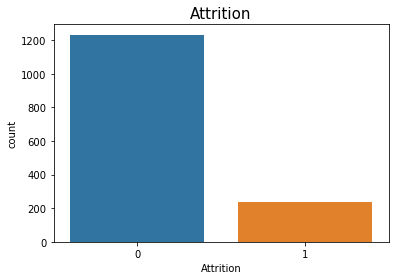

In [7]:
#Let's look at our target variable
print(df['Attrition'].value_counts(normalize=True))
sns.countplot(df['Attrition'])
plt.title("Attrition",fontsize=15)

So we're looking at only 16% of the employees in this dataset actually leaving the company.

## Data Visualization

### First, attrition by Job Role

In [8]:
def percent_attrition_df(feature):
    labels = list(df[feature].unique())

    attrition = df.groupby(df[feature])['Attrition'].sum()
    no_attrition = df[feature].value_counts() - df.groupby(df[feature])['Attrition'].sum()

    feature_attrition = pd.DataFrame(attrition)
    feature_no_attrition = pd.DataFrame(no_attrition)
    feature_no_attrition.rename(columns = {0: 'no_attrition'}, inplace = True)
    feature_df = feature_attrition.join(feature_no_attrition)

    feature_df['%_Attrition'] = feature_df['Attrition'] / feature_df['no_attrition']
    
    return feature_df

In [9]:
labels = list(df['JobRole'].unique())

attrition = df.groupby(df['JobRole'])['Attrition'].sum()
no_attrition = df['JobRole'].value_counts() - df.groupby(df['JobRole'])['Attrition'].sum()

job_role_attrition = pd.DataFrame(attrition)
job_role_no_attrition = pd.DataFrame(no_attrition)
job_role_no_attrition.rename(columns = {0: 'no_attrition'}, inplace = True)
job_role_df = job_role_attrition.join(job_role_no_attrition)

job_role_df['%_Attrition'] = (job_role_df['Attrition'] / (job_role_df['Attrition'] + job_role_df['no_attrition']))*100

In [10]:
def attrition_charts(labels, attrition_feature, no_attrition_feature, feature_df, feature):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

    ax[0].bar(labels, no_attrition_feature, label = 'No')
    ax[0].bar(labels, attrition_feature, bottom=no_attrition_feature, label = 'Yes')

    for rect in ax[0].patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
    
        # The height of the bar is the data value and can be used as the label
        label_text = f'{height}'  # f'{height:.2f}' to format decimal values
    
        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2

        # plot only when height is greater than specified value
        if height > 0:
            ax[0].text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)


    ax[0].set_ylabel('Num Employees')
    ax[0].set_title('Attrition by' + ' ' + feature)
    ax[0].set_xticklabels(labels, rotation=90)
    ax[0].legend()
    
    labels_ = feature_df.index.tolist()

    ax[1].bar(labels_, feature_df['%_Attrition'])
    ax[1].set_ylabel('% Employees')
    ax[1].set_title('Attrition Rate by' + ' ' + feature)
    ax[1].set_xticklabels(labels_, rotation=90)

    plt.show()

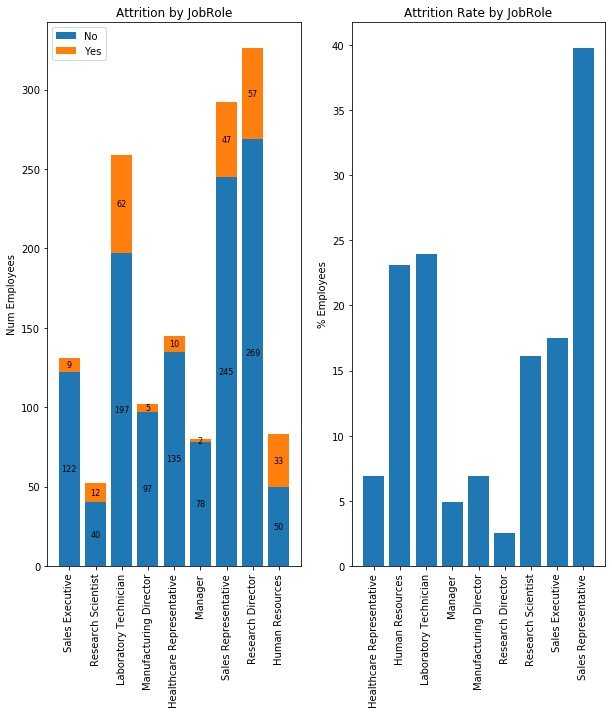

In [11]:
attrition_charts(labels, attrition, no_attrition, job_role_df, 'JobRole')

We see above that Sales Reps, HR employees, and Lab techs have the highest attrition rates. Below, we see that Sales Reps, Lab techs, and HR employees occupy 3 of the 4 lowest paid groups by monthly income.

In [12]:
df_income = df.groupby(df['JobRole'])['MonthlyIncome'].mean()
df_income.sort_values()

JobRole
Sales Representative          2626.000000
Laboratory Technician         3237.169884
Research Scientist            3239.972603
Human Resources               4235.750000
Sales Executive               6924.279141
Manufacturing Director        7295.137931
Healthcare Representative     7528.763359
Research Director            16033.550000
Manager                      17181.676471
Name: MonthlyIncome, dtype: float64

### Attrition by Monthly Income

In [13]:
rate_bins = pd.cut(df['MonthlyIncome'], bins = 8, labels = ['1000-3375', '3376-5750', 
                                                            '5751-8125', '8126-10500', 
                                                            '10501-12875', '12875-15250', 
                                                            '15251-17625', '17625-20000'])
df['MonthlyIncome_cut'] = rate_bins

labels = df['MonthlyIncome_cut'].cat.categories
ind = np.array([x for x, _ in enumerate(labels)])

attrition = df.groupby(df['MonthlyIncome_cut'])['Attrition'].sum()
no_attrition = df['MonthlyIncome_cut'].value_counts() - df.groupby(df['MonthlyIncome_cut'])['Attrition'].sum()

In [14]:
monthly_income_attrition = pd.DataFrame(attrition)
monthly_income_no_attrition = pd.DataFrame(no_attrition)
monthly_income_no_attrition.rename(columns = {0: 'no_attrition'}, inplace = True)

monthly_income_df = monthly_income_attrition.join(monthly_income_no_attrition)

monthly_income_df['%_Attrition'] = (monthly_income_df['Attrition'] / (monthly_income_df['Attrition'] + 
                                    monthly_income_df['no_attrition']))*100
monthly_income_df

,Attrition,no_attrition,%_Attrition
MonthlyIncome_cut,,,
1000-3375,121,327,27.008929
3376-5750,53,384,12.128146
5751-8125,23,186,11.004785
8126-10500,25,104,19.379845
10501-12875,5,55,8.333333
12875-15250,5,50,9.090909
15251-17625,0,54,0.000000
17625-20000,5,73,6.410256


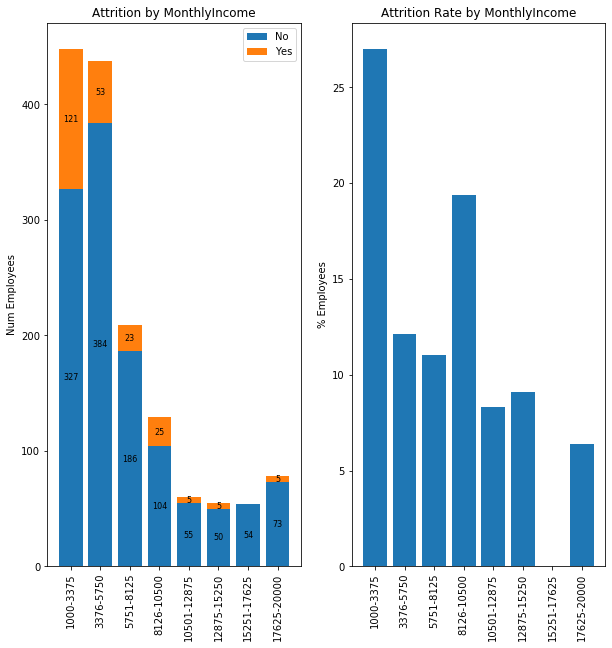

In [15]:
attrition_charts(labels, attrition, no_attrition, monthly_income_df, 'MonthlyIncome')

We see that mainly people on the lower end of monthly income are those most likely to leave. This makes sense because salary isn't tying them as much to their current job, and one of the most efficient ways of getting a raise is to change jobs. It's likely they aren't as happy as higher paid employees:

In [16]:
df_income = df.groupby(df['RelationshipSatisfaction'])['MonthlyIncome'].mean()
df_income.sort_values()

RelationshipSatisfaction
1    6177.793478
3    6543.773420
2    6596.983498
4    6601.296296
Name: MonthlyIncome, dtype: float64

The lowest earners on average are also least satisfied with their relationships at work.

### Attrition by Age

In [17]:
age_bins = pd.cut(df['Age'], bins = 7, labels = ['18-24', '24-30', '30-36', '36-42', '42-48', '48-54', '54-60'])
df['age_cut'] = age_bins

labels = df['age_cut'].cat.categories
ind = np.array([x for x, _ in enumerate(labels)])

attrition = df.groupby(df['age_cut'])['Attrition'].sum()
no_attrition = df['age_cut'].value_counts() - df.groupby(df['age_cut'])['Attrition'].sum()

In [18]:
age_attrition = pd.DataFrame(attrition)
age_no_attrition = pd.DataFrame(no_attrition)
age_no_attrition.rename(columns = {0: 'no_attrition'}, inplace = True)

age_df = age_attrition.join(age_no_attrition)

age_df['%_Attrition'] = (age_df['Attrition']/(age_df['Attrition'] + age_df['no_attrition']))*100
age_df

,Attrition,no_attrition,%_Attrition
age_cut,,,
18-24,38,59,39.175258
24-30,62,227,21.453287
30-36,66,346,16.019417
36-42,27,266,9.215017
42-48,19,163,10.439560
48-54,14,114,10.937500
54-60,11,58,15.942029


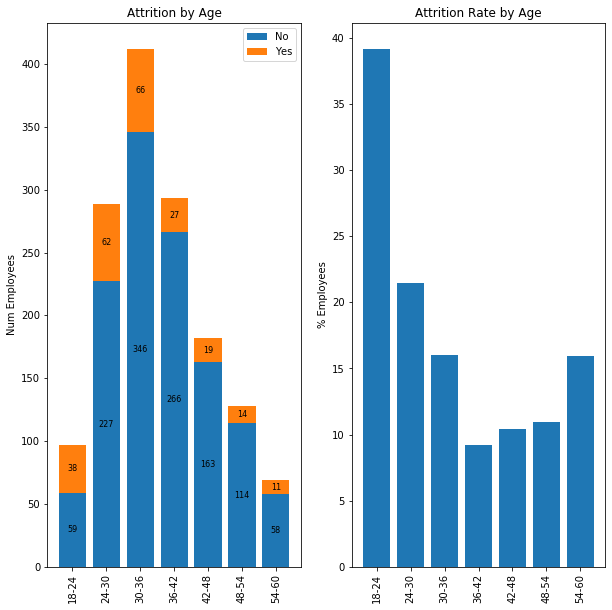

In [19]:
attrition_charts(labels, attrition, no_attrition,age_df, 'Age')

In general, we see that younger workers have the highest attrition rates - the 18-24 group is at nearly 40%. There is normally a higher supply of younger employees, and that age group tends to bounce around more jobs as they figure out what they want to do. They also don't assume as much risk as older employees who might crave the stability to support their families. Attrition rates start to rise again in the 42-48 age bracket. This could be because these employees are more highly paid and when companies are looking to cut costs, they'd go after this segment first. We can also imagine that attrition in the oldest age bracket could be due to retirements.

### Attrition by Education

In [20]:
df['Education'] = df['Education'].map({1: 'Below_College', 2: 'College', 3: 'Bachelor', 4: 'Master', 5: 'Doctor'})
labels = list(df['Education'].unique())

attrition = sorted(df.groupby(df['Education'])['Attrition'].sum())
no_attrition = sorted(df['Education'].value_counts() - df.groupby(df['Education'])['Attrition'].sum())

edu_attrition = pd.DataFrame(attrition)
edu_attrition.rename(columns = {0: 'attrition'}, inplace = True)
edu_no_attrition = pd.DataFrame(no_attrition)
edu_no_attrition.rename(columns = {0: 'no_attrition'}, inplace = True)

edu_df = edu_attrition.join(edu_no_attrition)

edu_df['%_Attrition'] = (edu_df['attrition']/(edu_df['attrition'] + edu_df['no_attrition']))*100
edu_df.set_index(df['Education'].unique(), inplace = True)
edu_df

,attrition,no_attrition,%_Attrition
College,5,43,10.416667
Below_College,31,139,18.235294
Master,44,238,15.602837
Bachelor,58,340,14.572864
Doctor,99,473,17.307692


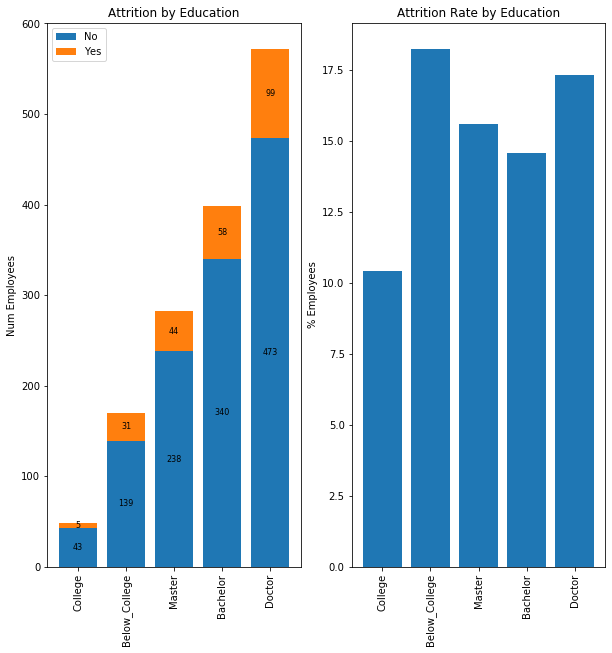

In [21]:
attrition_charts(labels, attrition, no_attrition, edu_df, 'Education')

Employees without a college degree have the highest attrition rate, but not by much. This likely due to these employees working in less stable jobs and earning less money. There are also high rates among doctorates and master's earners. Perhaps this is due to burnout from working stressful jobs.

### Attrition by distance from home


In [22]:
dist_bins = pd.cut(df['DistanceFromHome'], bins = 4, labels = ['1-7', '8-14', '15-21', '22-29'])
df['dist_cut'] = dist_bins

labels = df['dist_cut'].cat.categories
ind = np.array([x for x, _ in enumerate(labels)])

attrition = df.groupby(df['dist_cut'])['Attrition'].sum()
no_attrition = df['dist_cut'].value_counts() - df.groupby(df['dist_cut'])['Attrition'].sum()

In [23]:
dist_attrition = pd.DataFrame(attrition)
dist_no_attrition = pd.DataFrame(no_attrition)
dist_no_attrition.rename(columns = {0: 'no_attrition'}, inplace = True)

dist_df = dist_attrition.join(dist_no_attrition)

dist_df['%_Attrition'] = (dist_df['Attrition']/(dist_df['Attrition'] + dist_df['no_attrition']))*100
dist_df

,Attrition,no_attrition,%_Attrition
dist_cut,,,
1-7,115,740,13.450292
8-14,54,232,18.881119
15-21,32,130,19.753086
22-29,36,131,21.556886


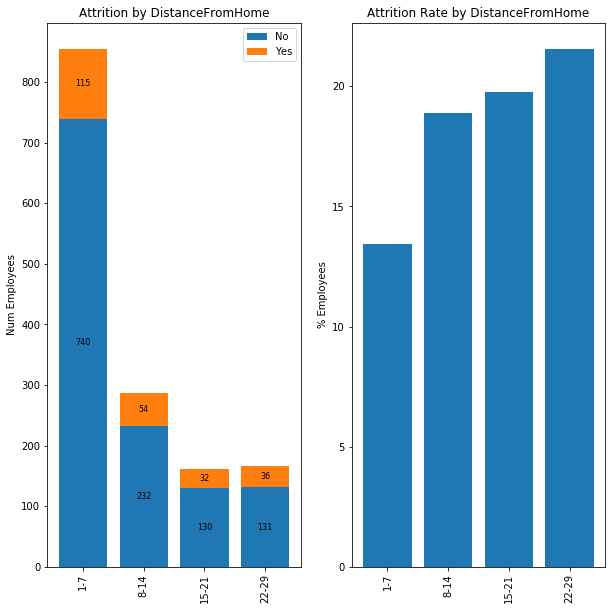

In [24]:
attrition_charts(labels, attrition, no_attrition, dist_df, 'DistanceFromHome')

This breakdown above makes logical sense - people who live far from their office will tire out more quickly with their commute than employees who live closer, leading them to look for other jobs.

### Attrition by total working years

In [25]:
years_bins = pd.cut(df['TotalWorkingYears'], bins = 10, labels = ['0-3', '4-7', '8-11', '12-15', '16-19', '20-23', '24-27',
                                                                 '28-31', '32-35', '36-40'])

df['years_cut'] = years_bins

labels = df['years_cut'].cat.categories
ind = np.array([x for x, _ in enumerate(labels)])

attrition = df.groupby(df['years_cut'])['Attrition'].sum()
no_attrition = df['years_cut'].value_counts() - df.groupby(df['years_cut'])['Attrition'].sum()

In [26]:
years_attrition = pd.DataFrame(attrition)
years_no_attrition = pd.DataFrame(no_attrition)
years_no_attrition.rename(columns = {0: 'no_attrition'}, inplace = True)

years_df = years_attrition.join(years_no_attrition)

years_df['%_Attrition'] = years_df['Attrition']/(years_df['Attrition'] + years_df['no_attrition'])
years_df

,Attrition,no_attrition,%_Attrition
years_cut,,,
0-3,75,153,0.328947
4-7,72,325,0.181360
8-11,47,335,0.123037
12-15,15,129,0.104167
16-19,12,100,0.107143
20-23,8,87,0.084211
24-27,3,46,0.061224
28-31,1,34,0.028571
32-35,2,19,0.095238


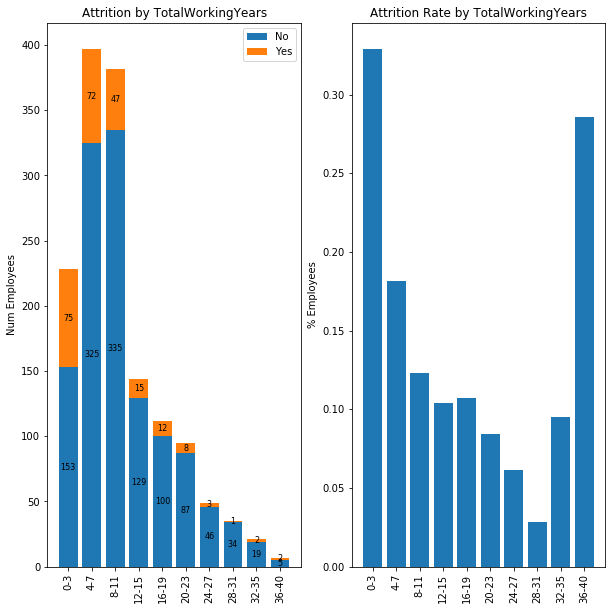

In [27]:
attrition_charts(labels, attrition, no_attrition, years_df, 'TotalWorkingYears')

Attrition rate decreases consistently as employees work more years until the 32-35 years bin. These employees are likely retiring.

### Attrition by job satisfaction

In [28]:
df['JobSatisfaction'] = df['JobSatisfaction'].map({1:'Low', 2:'Medium', 3: 'High', 4:'Very High'})

In [29]:
labels = sorted(list(df['JobSatisfaction'].unique()))

attrition = df.groupby(df['JobSatisfaction'])['Attrition'].sum()
no_attrition = df['JobSatisfaction'].value_counts() - df.groupby(df['JobSatisfaction'])['Attrition'].sum()

In [30]:
satisfaction_attrition = pd.DataFrame(attrition)
satisfaction_no_attrition = pd.DataFrame(no_attrition)
satisfaction_no_attrition.rename(columns = {0: 'no_attrition'}, inplace = True)

satisfaction_df = satisfaction_attrition.join(satisfaction_no_attrition)

satisfaction_df['%_Attrition'] = satisfaction_df['Attrition']/(satisfaction_df['Attrition'] + satisfaction_df['no_attrition'])
satisfaction_df.sort_values(by = 'no_attrition', inplace=True)

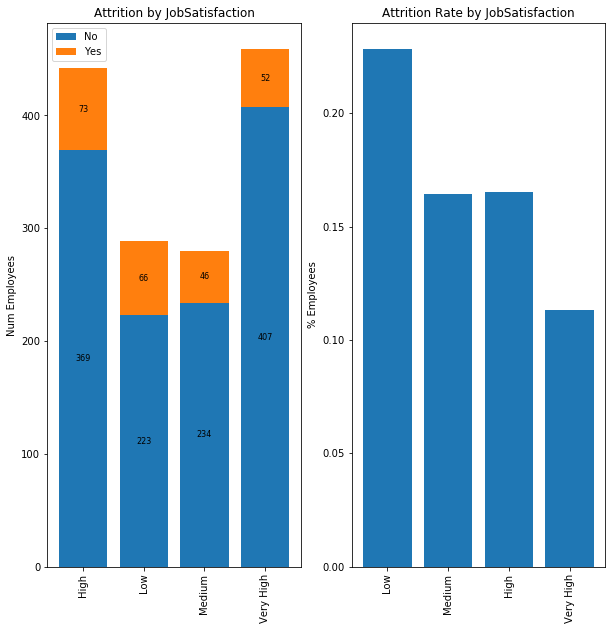

In [31]:
attrition_charts(labels, attrition, no_attrition, satisfaction_df, 'JobSatisfaction')

Attrition rate is clearly correlated with how satisfied you are with your job. Employees with low job satisfaction are by far the most likely employees to leave.

# Modeling

We will try a few different models to see which type of classifier best reduces the false negative rate. The first model will be a logistic regression model. These models are highly interpretable (each coefficient corresponds to a probability) and attempt to estimate a linear relationship.

In [32]:
df = pd.read_csv('HR_Employee_Attrition.csv')
df.drop(columns = ['Over18', 'EmployeeNumber', 'EmployeeCount', 'StandardHours'], axis=1, inplace = True)
df['Attrition'] = df['Attrition'].map({'Yes':1, 'No':0})

X = df.drop(columns=['Attrition'], axis=1)
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [33]:
ohe_cols = []
num_cols = []

for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        num_cols.append(col)
    else:
        ohe_cols.append(col)

### Logistic Regression

In [34]:
#Set up the preprocessing steps for both types of column. We'll use the MinMax scaler.
num_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

ohe_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat_ohe', ohe_transformer, ohe_cols)])

In [35]:
# Append classifier to preprocessing pipeline. We're going to start with a baseline regression model

clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression())])

clf_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'Education',
                                                   'EnvironmentSatisfaction',
                                                   'HourlyRate',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                        

<class 'numpy.ndarray'>
Train Scores
------------
Accuracy: 0.8974591651542649
Recall: 0.4431818181818182
F1 Score: 0.5799256505576208
ROC-AUC: 0.8740121244845866
--------------------
Test Scores
-----------
Accuracy: 0.8614130434782609
Recall: 0.32786885245901637
F1 Score: 0.4395604395604395
ROC-AUC: 0.8253324077535109


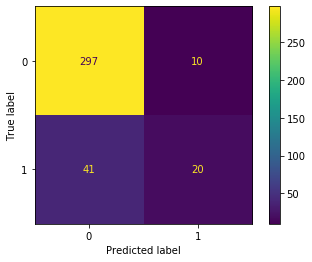

In [36]:
evaluate(clf_logreg, X_train, X_test, y_train, y_test)

Our baseline model didn't do very well in terms of recall (the metric which indicates we're minimizing our false negatives), and only slightly better than a random guess in terms of accuracy - our class breakdown was 84% in the negative case, so an accuracy of 86% on the test set implies that the model only improved 2 percentage points over a random guess. The model is also quite overfit. Next, we'll tune our parameters using grid search.

In [37]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression())])

#weights used here to help adjust for the class imbalance
#C is an inverse regularization parameter that helps prevent overfitting. The smaller C is, the more the model is penalized
param_grid = {'classifier__class_weight': [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}],
             'classifier__C': [.1, .5, 1, 100, 1e20],
             'classifier__penalty': ['l1', 'l2']}

In [38]:
search = GridSearchCV(clf_logreg, param_grid, n_jobs=-1, cv=5, scoring = 'recall') #setting scoring to recall

search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'DailyRate',
                                                                          'DistanceFromHome',
                                                                          'Education',
                                                                          'EnvironmentSatisfaction',
                                                                          'HourlyRate',
                                                                          'JobInvolvement',
      

<class 'numpy.ndarray'>
Train Scores
------------
Accuracy: 0.662431941923775
Recall: 0.9034090909090909
F1 Score: 0.4608695652173913
ROC-AUC: 0.870938052228549
--------------------
Test Scores
-----------
Accuracy: 0.6467391304347826
Recall: 0.8360655737704918
F1 Score: 0.43965517241379304
ROC-AUC: 0.8181235649062851


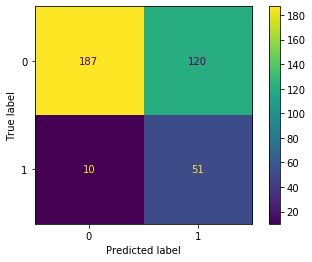

In [39]:
evaluate(search, X_train, X_test, y_train, y_test)

In [40]:
print(f"Best parameter's score: {search.best_score_:0.3f}):")
print(search.best_params_)

Best parameter's score: 0.846):
{'classifier__C': 0.1, 'classifier__class_weight': {1: 10, 0: 1}, 'classifier__penalty': 'l2'}


This model, with a C value of .1 and class weights of 10:1, resulted in a much better recall score of .84. We see in the above confusion matrix that there are only 10 false negatives (people the model failed to predict leaving the company), 2.7% of predictions. This model appears to be really reliable in figuring out which employees will leave.

Let's fit a logreg model with these best parameters and get our feature importances.

<class 'numpy.ndarray'>
Train Scores
------------
Accuracy: 0.662431941923775
Recall: 0.9034090909090909
F1 Score: 0.4608695652173913
ROC-AUC: 0.870938052228549
--------------------
Test Scores
-----------
Accuracy: 0.6467391304347826
Recall: 0.8360655737704918
F1 Score: 0.43965517241379304
ROC-AUC: 0.8181235649062851


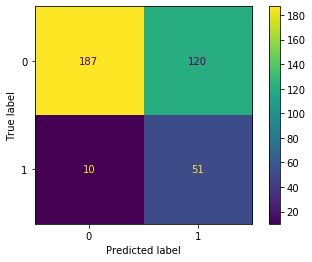

In [41]:
clf_logreg_best = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(C = .1, class_weight ={1: 10, 0: 1}))])

clf_logreg_best.fit(X_train, y_train)

evaluate(clf_logreg_best, X_train, X_test, y_train, y_test)

In [42]:
num_cols_2 = ['Age', 'DailyRate','DistanceFromHome','Education','EnvironmentSatisfaction','HourlyRate','JobInvolvement', 
              'JobLevel','JobSatisfaction','MonthlyIncome','MonthlyRate','NumCompaniesWorked','PercentSalaryHike',
              'PerformanceRating','RelationshipSatisfaction','StockOptionLevel','TotalWorkingYears',
              'TrainingTimesLastYear','WorkLifeBalance','YearsAtCompany',
                'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
ohe_cols_2 = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
X_num = X[num_cols_2]
X_ohe = X[ohe_cols_2]
X_ohe_processed = pd.get_dummies(X_ohe)
X_new = pd.concat([X_num, X_ohe_processed])

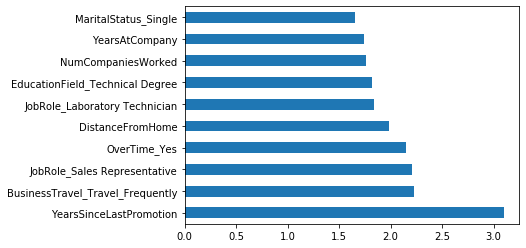

In [43]:
#converting to from log odds below using np.exp

importance = np.exp(clf_logreg_best.steps[1][1].coef_)
importance = importance.reshape(51,)

(pd.Series(importance, index=X_new.columns).nlargest(10).plot(kind='barh')) 

What this is telling us is that for every additional year someone is not promoted, the odds of them leaving the company triple, holding all else equal. Each feature shown above follows this interpretation. For example, employees who work overtime are more than twice as likely to leave as those who don't.

We might not do better than this model, but let's move on to Naive Bayes and see how we do.

### Naive Bayes

We'll be using Gaussian Bayes because the predictors are mainly continuous values. We do have some categorical variables which it should also handle fairly well. One issue is that Naive Bayes assumes independence among the features of the model, and there are clear correlations between many of the variables here.

In [44]:
clf_gnb = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', GaussianNB())])

clf_gnb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'Education',
                                                   'EnvironmentSatisfaction',
                                                   'HourlyRate',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                        

<class 'bool'>
Train Scores
------------
Accuracy: 0.6941923774954628
Recall: 0.7670454545454546
F1 Score: 0.44481054365733114
--------------------
Test Scores
-----------
Accuracy: 0.6820652173913043
Recall: 0.639344262295082
F1 Score: 0.39999999999999997


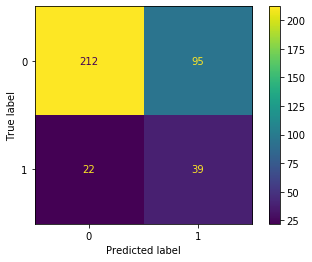

In [45]:
evaluate(clf_gnb, X_train, X_test, y_train, y_test, use_decision_function = 'skip')

The model has decent recall scores but not as good as what we saw with logistic regression. There aren't really any parameters to tune in a Bayes model, but at the end of this notebook, we'll test the model on log transformed data to see if the scores improve.

## Tree-Based Models

First, we'll try our a basic decision tree. Decision trees are also interpretable. When discussing feature importance in a decision tree, we are talking about which features led to the most learned information when making a decision. So when a tree comes to a node, important features make this decision easier and more accurate.

If this model is unsuccessful, we'll skip random forests and move straight to XGBoost. Let's test our recall scores by iterating through various parameters and figure how to tune each one.

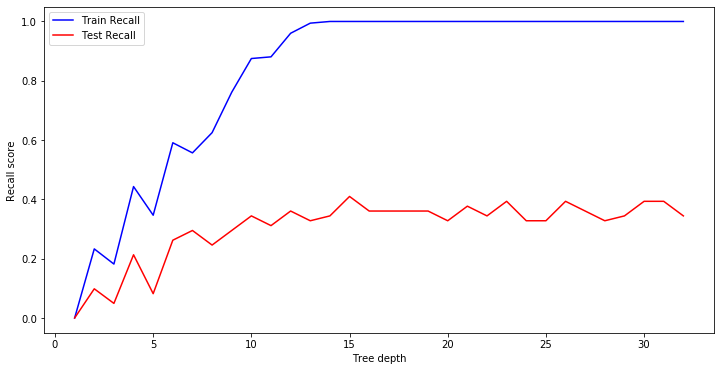

In [46]:
max_depth = range(1,33)
train_results = []
test_results = []
for m in max_depth:
    clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', DecisionTreeClassifier(criterion = 'entropy', max_depth=m))])

    clf_dt.fit(X_train, y_train)
#     clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=m, random_state = 1)
#     #training data
#     clf.fit(X_train, y_train)
    y_pred_train = clf_dt.predict(X_train)
    recall = recall_score(y_train, y_pred_train)
    train_results.append(recall)

    #test data
    y_pred = clf_dt.predict(X_test)
    recall = recall_score(y_test, y_pred)
    test_results.append(recall)
    
plt.figure(figsize=(12,6))
plt.plot(max_depth, train_results, 'b', label='Train Recall')
plt.plot(max_depth, test_results, 'r', label='Test Recall')
plt.ylabel('Recall score')
plt.xlabel('Tree depth')
plt.legend()
plt.show() 

Around 6-8 looks right as anymore will lead to serious overfit.

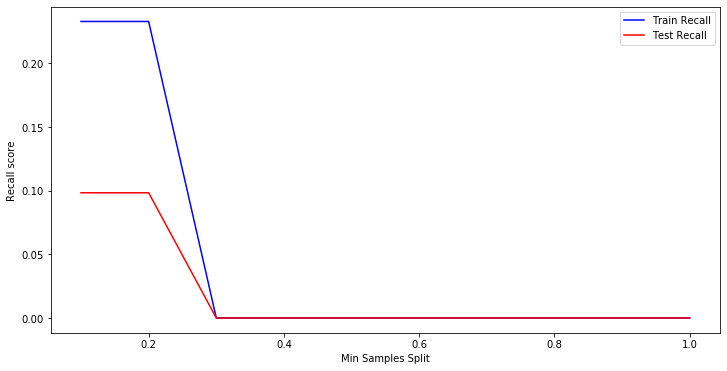

In [47]:
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for m in min_samples_split:
    clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', DecisionTreeClassifier(criterion = 'entropy', min_samples_split = m))])

    clf_dt.fit(X_train, y_train)
    y_pred_train = clf_dt.predict(X_train)
    recall = recall_score(y_train, y_pred_train)
    train_results.append(recall)

    #test data
    y_pred = clf_dt.predict(X_test)
    recall = recall_score(y_test, y_pred)
    test_results.append(recall)
    
plt.figure(figsize=(12,6))
plt.plot(min_samples_split, train_results, 'b', label='Train Recall')
plt.plot(min_samples_split, test_results, 'r', label='Test Recall')
plt.ylabel('Recall score')
plt.xlabel('Min Samples Split')
plt.legend()
plt.show() 

.1 - .2 for our split is our best bet.

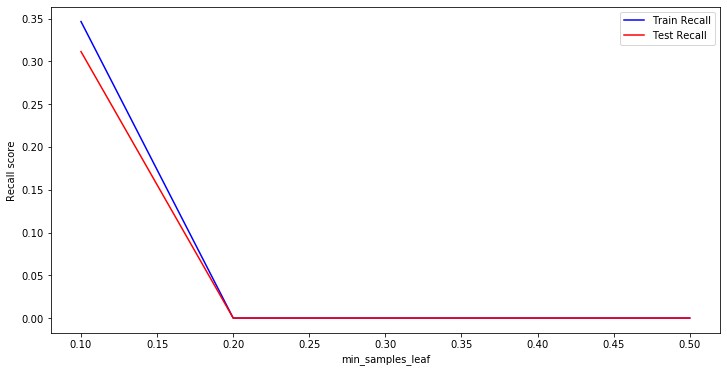

In [48]:
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for m in min_samples_leaf:
    clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = m))])

    clf_dt.fit(X_train, y_train)
    y_pred_train = clf_dt.predict(X_train)
    recall = recall_score(y_train, y_pred_train)
    train_results.append(recall)

    #test data
    y_pred = clf_dt.predict(X_test)
    recall = recall_score(y_test, y_pred)
    test_results.append(recall)
    
plt.figure(figsize=(12,6))
plt.plot(min_samples_leaf, train_results, 'b', label='Train Recall')
plt.plot(min_samples_leaf, test_results, 'r', label='Test Recall')
plt.ylabel('Recall score')
plt.xlabel('min_samples_leaf')
plt.legend()
plt.show()

.1-.12

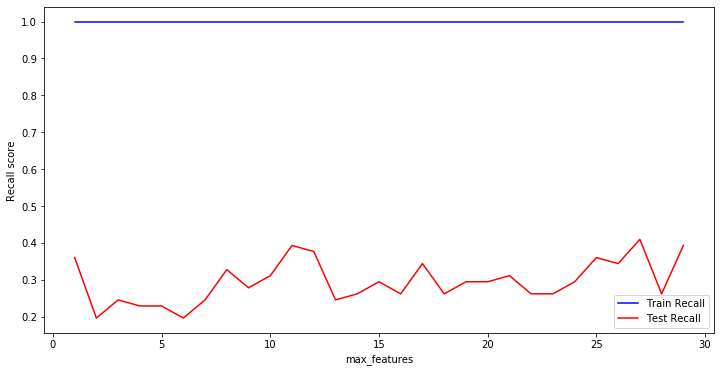

In [49]:
max_features = range(1,30)
train_results = []
test_results = []
for m in max_features:
    clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', DecisionTreeClassifier(criterion = 'entropy', max_features = m))])

    clf_dt.fit(X_train, y_train)
    y_pred_train = clf_dt.predict(X_train)
    recall = recall_score(y_train, y_pred_train)
    train_results.append(recall)

    #test data
    y_pred = clf_dt.predict(X_test)
    recall = recall_score(y_test, y_pred)
    test_results.append(recall)
    
plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train Recall')
plt.plot(max_features, test_results, 'r', label='Test Recall')
plt.ylabel('Recall score')
plt.xlabel('max_features')
plt.legend()
plt.show() 

We shouldn't tune with max features as the recall is perfect on the train set, implying massive overfit

In [50]:
#time for our model

clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', DecisionTreeClassifier())])

param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [6, 7, 8],
    'classifier__min_samples_split': [.1, .2],
    'classifier__min_samples_leaf': [.1, .2]
}

search = GridSearchCV(clf_dt, param_grid, n_jobs=-1, cv=5, scoring = 'recall', return_train_score=True)

search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'DailyRate',
                                                                          'DistanceFromHome',
                                                                          'Education',
                                                                          'EnvironmentSatisfaction',
                                                                          'HourlyRate',
                                                                          'JobInvolvement',
      

<class 'bool'>
Train Scores
------------
Accuracy: 0.8493647912885662
Recall: 0.3465909090909091
F1 Score: 0.42361111111111116
--------------------
Test Scores
-----------
Accuracy: 0.8315217391304348
Recall: 0.3114754098360656
F1 Score: 0.38


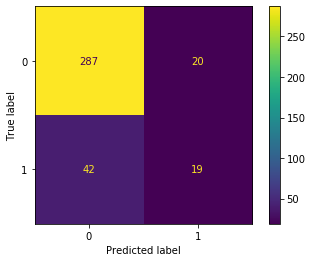

In [51]:
evaluate(search, X_train, X_test, y_train, y_test, use_decision_function = 'skip')

In [52]:
search.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 0.1,
 'classifier__min_samples_split': 0.1}

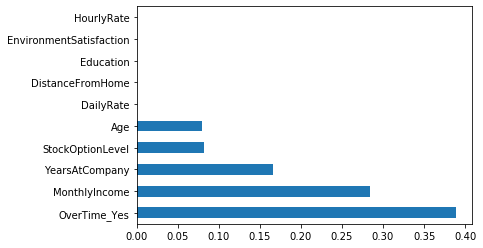

In [53]:
importance = search.best_estimator_.steps[1][1].feature_importances_

pd.Series(importance, index=X_new.columns).nlargest(10).plot(kind='barh')

We see some overlap in terms of feature importance with the logistic regression model, with features like Overtime and years at the company, but also new ones like stock option level and age.

The model doesn't appear to be overfit at all, but the recall scores are quite low, with a false negative rate of 11.4%. It's unlikely for this to do better than Bayes or Logistic regression. Let's move on to a boosted tree.

### XGBoost

XGBoost is a type of gradient boosted algorithm. It outperforms nearly all other classification algorithms so it should certainly be used here. Boosted trees deal well with class imbalances and are resilient against noisy data and overfitting.

In [54]:
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', XGBClassifier())])

xgb_param_grid = {
    'classifier__learning_': [.1, .2],
    'classifier__max_depth': [5, 6, 7],
    'classifier__min_child_weight': [2, 4],
    'classifier__subsample': [.5],
    'classifier__gamma': [1, 2, 3]
}
    
search = GridSearchCV(clf_xgb, xgb_param_grid, cv=5, scoring = 'recall', return_train_score=True)
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'DailyRate',
                                                                          'DistanceFromHome',
                                                                          'Education',
                                                                          'EnvironmentSatisfaction',
                                                                          'HourlyRate',
                                                                          'JobInvolvement',
      

<class 'bool'>
Train Scores
------------
Accuracy: 0.9473684210526315
Recall: 0.6818181818181818
F1 Score: 0.8053691275167784
--------------------
Test Scores
-----------
Accuracy: 0.8586956521739131
Recall: 0.2786885245901639
F1 Score: 0.3953488372093023


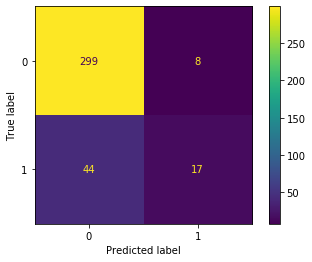

In [55]:
evaluate(search, X_train, X_test, y_train, y_test, use_decision_function = 'skip')

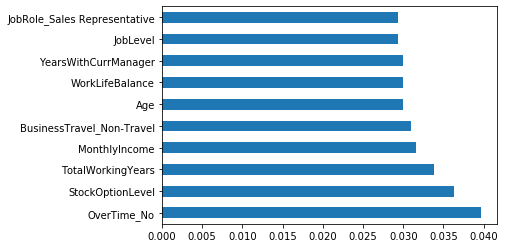

In [56]:
importance = search.best_estimator_.steps[1][1].feature_importances_

pd.Series(importance, index=X_new.columns).nlargest(10).plot(kind='barh')

We are dealing with massive overfitting here as well, but even so, the training recall isn't as good as our previous logreg models. We will focus exclusively on iterating and improving the logreg model as our final version.

## Final Model: Logistic Regression

In [57]:
cols_to_log = ['DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 
                'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A5BEB5BCC0>,
      dtype=object)

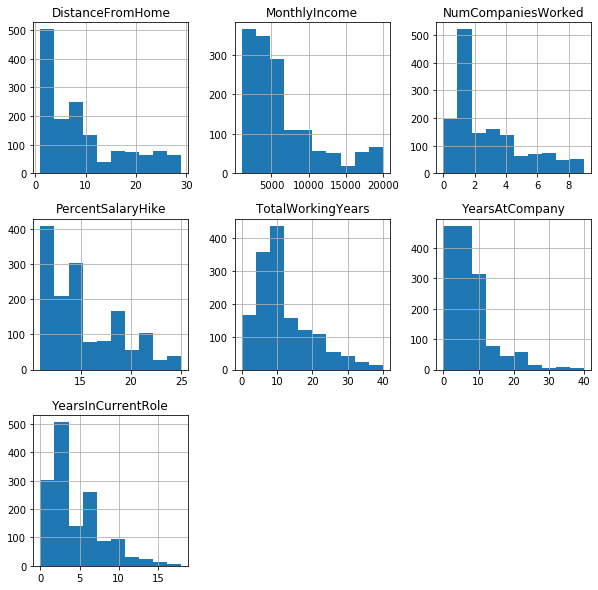

In [58]:
df[cols_to_log].hist(figsize=[10,10])

### Tuning further and trying with logged continuous variables

We'll be log transforming the above continuous, non-normal variables to hopefully improve our logistic model.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [60]:
#changing 0s to 1s so we can log these
X_log_names_train = X_train[cols_to_log]
X_log_names_test = X_test[cols_to_log]


X_log_names_train['TotalWorkingYears'] = X_log_names_train['TotalWorkingYears'].replace(0, 1)
X_log_names_train['NumCompaniesWorked'] = X_log_names_train['NumCompaniesWorked'].replace(0, 1)
X_log_names_train['YearsAtCompany'] = X_log_names_train['YearsAtCompany'].replace(0, 1)
X_log_names_train['YearsInCurrentRole'] = X_log_names_train['YearsInCurrentRole'].replace(0, 1)

X_log_names_test['TotalWorkingYears'] = X_log_names_test['TotalWorkingYears'].replace(0, 1)
X_log_names_test['NumCompaniesWorked'] = X_log_names_test['NumCompaniesWorked'].replace(0, 1)
X_log_names_test['YearsAtCompany'] = X_log_names_test['YearsAtCompany'].replace(0, 1)
X_log_names_test['YearsInCurrentRole'] = X_log_names_test['YearsInCurrentRole'].replace(0, 1)

In [61]:
log_names_train = [f'{column}_log' for column in X_log_names_train.columns]
X_log_train = np.log(X_log_names_train)
X_log_train.columns = log_names_train

log_names_test = [f'{column}_log' for column in X_log_names_test.columns]
X_log_test = np.log(X_log_names_test)
X_log_test.columns = log_names_test

In [62]:
no_log_cols = []
for col in num_cols:
    if col not in cols_to_log:
        no_log_cols.append(col)

In [63]:
X_ohe_train = X_train[ohe_cols]
X_ohe_train = pd.get_dummies(X_ohe_train)

X_ohe_test = X_test[ohe_cols]
X_ohe_test = pd.get_dummies(X_ohe_test)

X_train_nlog = X_train[no_log_cols]
X_test_nlog = X_test[no_log_cols]

X_train_preprocessed = pd.concat([X_log_train.reset_index(drop=True), 
                                  X_train_nlog.reset_index(drop=True), X_ohe_train.reset_index(drop=True)], axis=1)
X_test_preprocessed = pd.concat([X_log_test.reset_index(drop=True), X_test_nlog.reset_index(drop=True), 
                                 X_ohe_test.reset_index(drop=True)], axis=1)

In [64]:
minmax_scaler = MinMaxScaler()
X_train_preprocessed_scaled = minmax_scaler.fit_transform(X_train_preprocessed)
X_test_preprocessed_scaled = minmax_scaler.transform(X_test_preprocessed)

<class 'numpy.ndarray'>
Train Scores
------------
Accuracy: 0.6687840290381125
Recall: 0.9034090909090909
F1 Score: 0.465592972181552
ROC-AUC: 0.876086049479678
--------------------
Test Scores
-----------
Accuracy: 0.6440217391304348
Recall: 0.8524590163934426
F1 Score: 0.44255319148936173
ROC-AUC: 0.8217546857478507


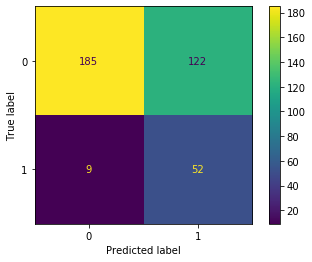

In [65]:
clf_logreg_best = LogisticRegression(C = .1, class_weight ={1: 10, 0: 1})

clf_logreg_best.fit(X_train_preprocessed_scaled, y_train)

evaluate(clf_logreg_best, X_train_preprocessed_scaled, X_test_preprocessed_scaled, y_train, y_test)

While still slightly overfit, log-transforming the non-normal variables improved the recall scores and reduced the false negative rate. The F1 score was also slightly improved.

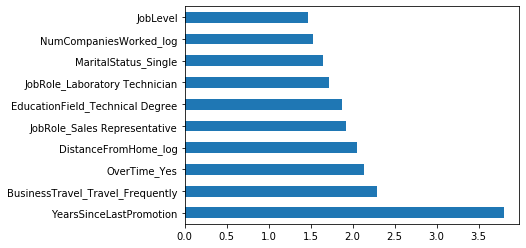

In [66]:
importances = np.exp(clf_logreg_best.coef_)
importances = importances.reshape(51,)

pd.Series(importances, index=X_train_preprocessed.columns).nlargest(10).plot(kind='barh')

Before we move to conclusions, let's test out Naive Bayes with the log-transformed continuous variables.

<class 'bool'>
Train Scores
------------
Accuracy: 0.7323049001814882
Recall: 0.7386363636363636
F1 Score: 0.46846846846846846
--------------------
Test Scores
-----------
Accuracy: 0.717391304347826
Recall: 0.5737704918032787
F1 Score: 0.4022988505747126


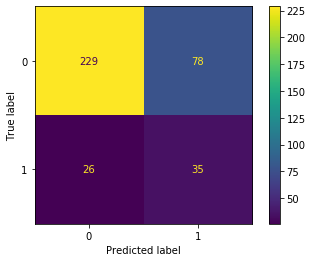

In [67]:
#naive bayes on log transformed vars:

clf_gnb_new = GaussianNB()

clf_gnb_new.fit(X_train_preprocessed_scaled, y_train)

evaluate(clf_gnb_new, X_train_preprocessed_scaled, X_test_preprocessed_scaled, y_train, y_test, use_decision_function = 'skip')

Test scores actually are worse than before I logged the continuous variables.

## Feature Importances

The most important feature in the logistic regression model, as discussed before, is the number of years since last promotion, which increases the odds of an employee leaving by more than 3-fold for each additional year that employee is passed over for a promotion. 

This is different from our tree-based models. In logistic regression, the coefficients are calculated with all features input into the model, while with a tree-based model, features are evaluated separately at specific nodes. This means that if we have collinear features, that could be impacting our feature importances in the logistic regression model. If two features are highly correlated with each other, it might just choose one arbitrarily. Although the results of the logistic model are highly interpretable, we may need to address multicollinearity, which will be tackled in future work.

In our XGBoost model, the most important feature is an employee who doesn't work overtime. This means that when the model makes a decision at a node, an employee who doesn't work overtime gave the model its largest information gain in the context of its prediction.

In our decision tree classifier, the model only found 5 features of any importance. They are the following in order by importance:
- Overtime_yes
- Monthly income
- Years worked at the company
- Stock option level
- Age

Interestingly, we only see overlap with one feature with the logistic regression model (overtime_yes). These differences are key to understanding how the model makes decisions with our preferred scoring metric, recall, in mind. The XGBoost model and the decision tree model were highly overfit on the training data and underperformed Naive Bayes and logistic regression in terms of recall score. 

In this context, minimizing the false negative rate is most important to us. The smaller it is, the better our model is doing at predicting which employees will leave the company. Our best model, logistic regression, does sacrifice some accuracy and precision, but having a high false positive rate is not necessarily damaging to a company. Our model misclassifed 39% of employees who didn't leave the company. This is a large percentage, but in this context, it is likely less costly to assume more employees might leave than actually do, than missing employees who actually leave. The company would likely invest more in retaining employees who weren't going to leave anyway, but this wouldn't harm the company. Expenses might rise, but you'll have a happier firm overall in theory. The rise in productivity would likely offset the investment to retain these employees.

## Evaluation and Conclusions

The following are the test scores from the best iteration of each model used above.

#### Logistic Regression (best model):

- Accuracy: 0.644
- Recall: 0.85
- F1 Score: 0.44
- ROC-AUC: 0.82


#### Naive Bayes:

- Accuracy: 0.68
- Recall: 0.64
- F1 Score: 0.40


#### Decision Tree:

- Accuracy: 0.83
- Recall: 0.31
- F1 Score: 0.38

#### XGBoost:

- Accuracy: 0.86
- Recall: 0.28
- F1 Score: 0.40

As mentioned before, logistic regression offers our best model as it results in the highest recall score. It misclassified only 9 employees who actually left the company, for a false negative rate of 2.4%. It's true positive rate was 85%, identifying 52 of the 61 employees who left the company in the test set. Overall, it correctly predicted 65% of employees' decisions.

The Naive Bayes had a worse recall score but correctly predicted 72% of employees' decisions. Finally, the XGBoost model had the worst recall score but correctly predicted 86% of employees' decisions.

In the real world, our modeling here can help companies address issues employees have with their job before the decided to leave (or poor performance ends up in being let go). An employer can hopefully identify which employees they could be at risk of losing, and properly invest resources into retaining them and making them happier. The logistic regression model identified the following five features as the most important in predicting attrition:

- Years since last promotion
- Frequent business travel
- Working overtime
- Distance from home
- Job role = Sales representative

For the first three features, employers can easily address these issues. The promotion process can be overhauled and the firm should investigate why it's not promoting some employees who deserve it based on performance. The firm can also limit business travel and overtime as to prevent burnout. These employees are hardworking and likely contribute a large percentage of a company's bottom line. Distance from home is harder to address because employees choose where they want to live, but firms could institute a more flexible remote-working policy so employees who live farther away don't need to come into the office as often. Sales representatives are generally high-turnover roles across all industries. These jobs often have lower salaries which are offset by the promise of commissions. A company should pay their sales reps fairly - employees who believe they have poor compensation are not going to stay. Sales is a high-stress job, and employers should work to reduce this stress and compensate appropriately.

In terms of future work, I'd like to gather more data across different industries. 1500 employees is a small sample and is likely contributing to our issues of overfit in our tree-based models. Having good samples from various types of work can provide extremely useful data and a wholistic view of why employees leave.

I'd also want to ensure that this model and the data behind it is used ethically. For example, gender and race should probably be exluded from any model as to avoid bias from employers. [According to the Center for American Progress](https://www.americanprogress.org/issues/economy/reports/2019/12/05/478150/african-americans-face-systematic-obstacles-getting-good-jobs/), Black workers face far higher unemployment rates than white workers, and when they do get jobs, they're paid systematically less than white employees. In addition, Black workers earn fewer benefits and work in less stable industries than white workers. Data scientists developing machine learning algorithms in this space (and across ML applications) must work to remove biases from their models. Future work on this model should focus on not introducing racial or gender bias into the model, and ensure that employers can't abuse this model and use it as an excuse to fire employees they do not like.